Files already downloaded and verified
Files already downloaded and verified


Using cache found in /home/tianjunchao/.cache/torch/hub/pytorch_vision_v0.9.0
/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.003s...
[t-SNE] Computed neighbors for 50000 samples in 40.505s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sa

/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 111.483711
[t-SNE] KL divergence after 1000 iterations: 3.937344


/tmp/ipykernel_1882328/360409954.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_labels, cmap=plt.cm.get_cmap('jet', 10))


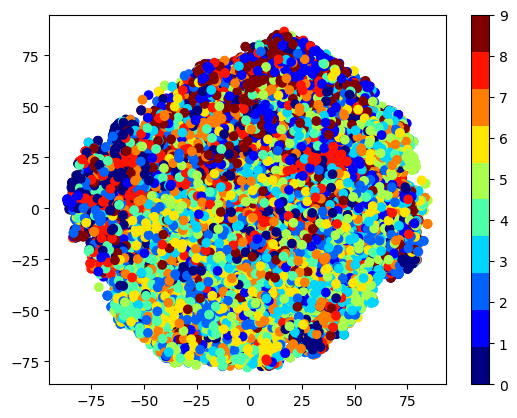

In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt



# 用pca降维为50维度，然后用tsne降维为2维度
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def get_tsne_features(features):
    features = PCA(n_components=50).fit_transform(features)
    features = TSNE(verbose=1,learning_rate='auto',init='pca').fit_transform(features)
    return features


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 加载 CIFAR-10 数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # 标准化
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# 创建 DataLoader 对象
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 加载预训练的 ResNet-18 模型
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True).to(device)
# 移除预训练模型的最后一层全连接层
modules = list(model.children())[:-1]
model = nn.Sequential(*modules)

# 提取训练集和测试集上的特征
train_features = []
train_labels = []
for images, labels in train_loader:
    images = images.to(device)
    features = model(images)
    train_features.append(features.cpu().detach())
    train_labels.append(labels)
train_features = torch.cat(train_features, dim=0).squeeze()
train_labels = torch.cat(train_labels, dim=0)

test_features = []
test_labels = []
for images, labels in test_loader:
    images = images.to(device)
    features = model(images)
    test_features.append(features.cpu().detach())
    test_labels.append(labels)
test_features = torch.cat(test_features, dim=0).squeeze()
test_labels = torch.cat(test_labels, dim=0)

# 使用 t-SNE 算法将特征可视化为 2D 空间
# tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, learning_rate=200)
# train_tsne = tsne.fit_transform(train_features)
train_tsne = get_tsne_features(train_features)
# 可视化 t-SNE 结果
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_labels, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar()
plt.show()


In [5]:
print(train_features.shape)

torch.Size([50000, 512, 1, 1])


In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 定义ResNet18模型
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Sequential(*list(torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True).children())[4:-1])
        )
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载CIFAR10数据集
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

# 实例化ResNet18模型
net = ResNet18()

# 提取CIFAR10的ResNet18特征
features = []
labels = []
for data in trainloader:
    inputs, target = data
    features.append(net.resnet(inputs).detach().numpy())
    labels.append(target.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# 使用t-SNE进行可视化
tsne = TSNE(n_components=2, random_state=0)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(10, 10))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar()
plt.title('t-SNE visualization of ResNet18 features on CIFAR10')
plt.show()


Files already downloaded and verified


Using cache found in /home/tianjunchao/.cache/torch/hub/pytorch_vision_v0.9.0
/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# 定义ResNet18模型
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.resnet = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Sequential(*list(torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True).children())[4:-1])
        )
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载CIFAR10数据集
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

# 实例化ResNet18模型
net = ResNet18()

# 冻结ResNet18模型的参数
for param in net.resnet.parameters():
    param.requires_grad = False

# 定义新的fc层
new_fc = nn.Linear(512, 10)

# 替换原始模型的fc层
net.fc = new_fc

# 定义优化器和损失函数
optimizer = optim.SGD(net.fc.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# 训练新的fc层
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.

# 提取CIFAR10的ResNet18特征
features = []
labels = []
for data in trainloader:
    inputs, target = data
    features.append(net.resnet(inputs).detach().numpy())
    labels.append(target.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# 使用t-SNE进行可视化
features_tsne = get_tsne_features(features)

plt.figure(figsize=(10, 10))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels)
plt.colorbar()
plt.show()


Files already downloaded and verified


Using cache found in /home/tianjunchao/.cache/torch/hub/pytorch_vision_v0.9.0
/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data0/tianjunchao/anaconda3/envs/tian/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 